<a href="https://colab.research.google.com/github/goelpravin/practice/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-jhv58loc
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-jhv58loc
  Created wheel for tensorflow-examples: filename=tensorflow_examples-2c3f811eec0c3410bc1307c05ee44721866fa86c_-cp36-none-any.whl size=135362 sha256=16ab02902c62fe31074b814629a9c299ad7aec6d8079021e67937654869bd609
  Stored in directory: /tmp/pip-ephem-wheel-cache-f419mknj/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
     |████████████████████████████████| 3.5MB 3.3MB/s 


In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteNZS134/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteNZS134/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
import tensorflow as tf
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def getImageMaskWithAug(datapoint):
  image = tf.image.resize(datapoint['image'], (128, 128))
  mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  random_for_aug = tf.random.uniform(())
  #if random_for_aug > 0.3 and  random_for_aug <0.6:
  if random_for_aug > 0.5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
  #elif random_for_aug < 0.3:
    #image = tf.image.rot90(image)
    #mask = tf.image.rot90(mask)

  image, mask = normalize(image, mask)
  return image, mask
def getImageMaskWithoutAug(datapoint):
  image = tf.image.resize(datapoint['image'], (128, 128))
  mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  image, mask = normalize(image, mask)
  return image, mask


In [ ]:
import numpy as np

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
train = dataset['train'].map(getImageMaskWithAug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#print(type(train_ds))
test = dataset['test'].map(getImageMaskWithoutAug)
batch_size_training = 128
batch_size_validation = 32
BUFFER_SIZE = 1000
train_ds = train.cache().shuffle(BUFFER_SIZE).batch(batch_size_training).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
test_ds = test.batch(batch_size_validation).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    for image, mask in train.take(num):
      display([image, mask])


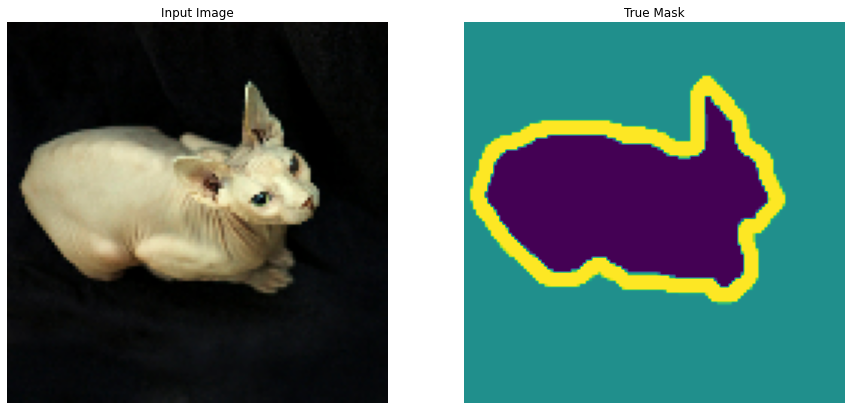

In [ ]:
def create_mask(pred_mask):
  #print("pred mask",pred_mask)
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

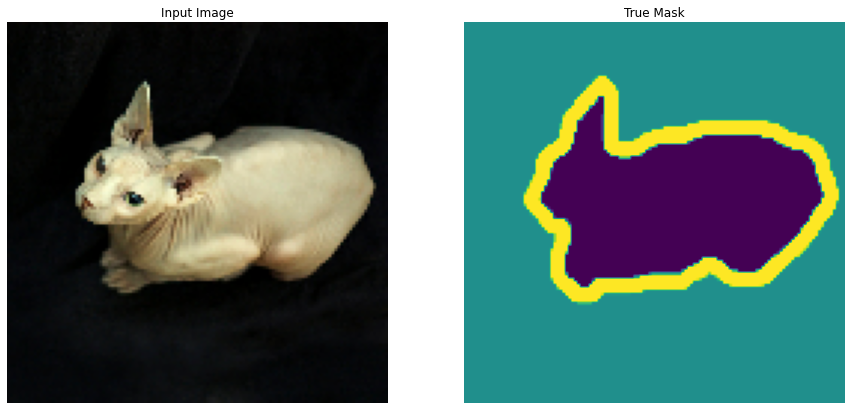

In [ ]:
show_predictions()

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.optimizers import Adam
OUTPUT_CHANNELS = 3
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def compute_loss(labels, predictions):
  print("labels=",labels)
  print("predictions=",predictions)
  per_example_loss = loss_object(labels, predictions)
  #per_example_loss /= tf.cast(
   #   tf.shape(labels)[1] * tf.shape(labels)[2], tf.float32)  # <--- See if this fixes the NaNs.
  return tf.nn.compute_average_loss(per_example_loss)
      #per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False


up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)
print("test")
model.compile(optimizer=Adam(lr=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss=compute_loss,
              metrics=['accuracy'])


test


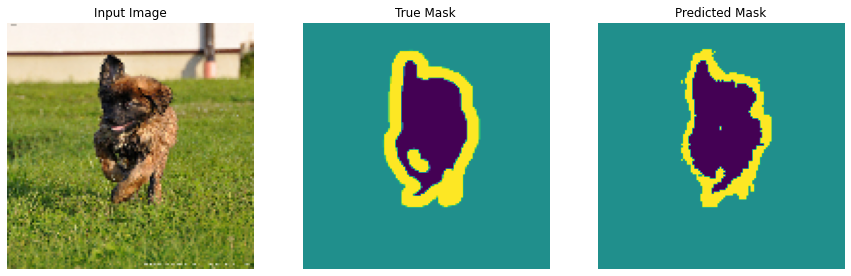


Reached 80% accuracy, so stopping further epochs
28/28 - 21s - loss: 0.1536 - accuracy: 0.9311 - val_loss: 0.3036 - val_accuracy: 0.8863


In [ ]:
from IPython.display import clear_output
class myCallback (tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    clear_output(wait=True)
    show_predictions(test_ds)
    if(logs.get('accuracy')>0.8):
      print("\nReached 80% accuracy, so stopping further epochs")
      #self.model.stop_training = True
callbacks = myCallback()


num_training_images = info.splits['train'].num_examples
epoch_steps = num_training_images//batch_size_training

num_testing_images = info.splits['test'].num_examples
validation_steps = num_testing_images//batch_size_validation

history = model.fit(
      train_ds,
      steps_per_epoch=epoch_steps,
      epochs=10,
      verbose=2,
      validation_data = test_ds,
      validation_steps=validation_steps,
      callbacks=[callbacks])

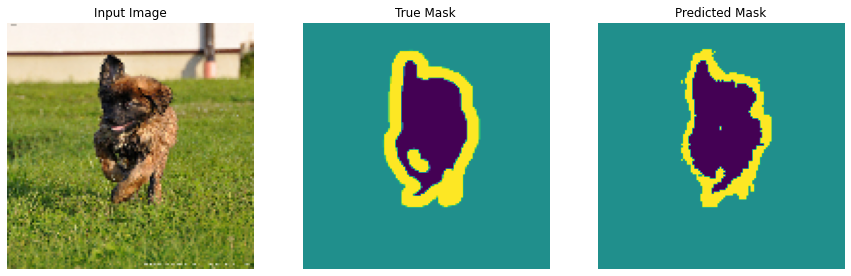

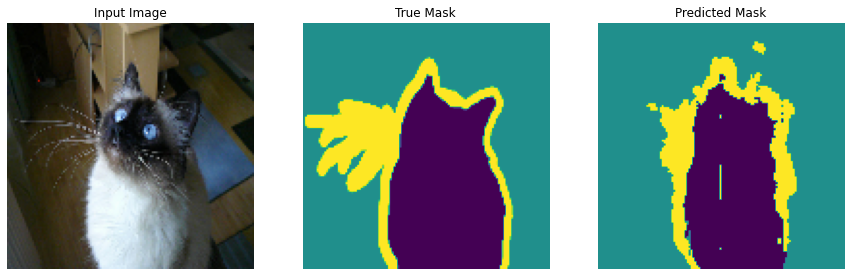

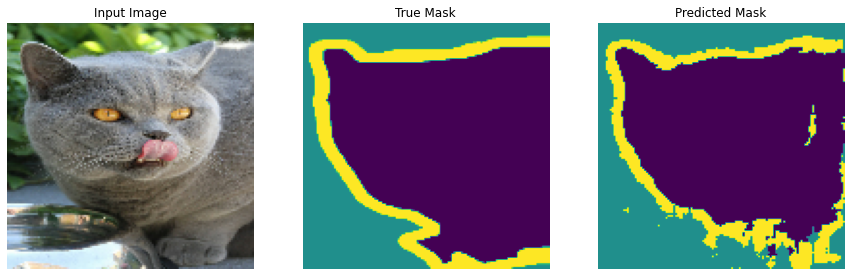

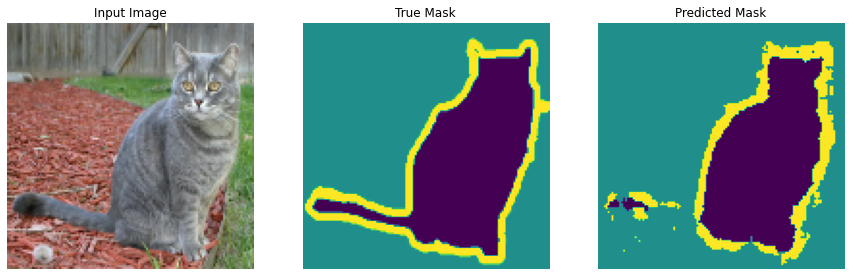

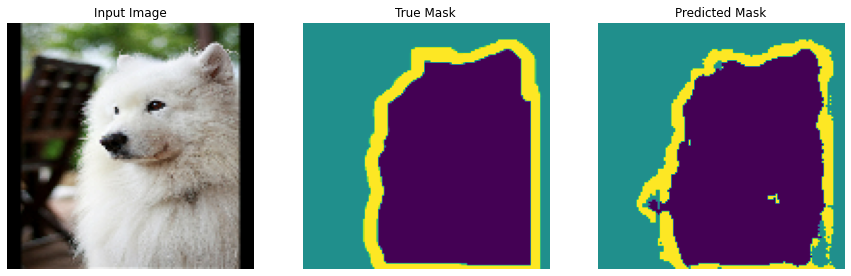

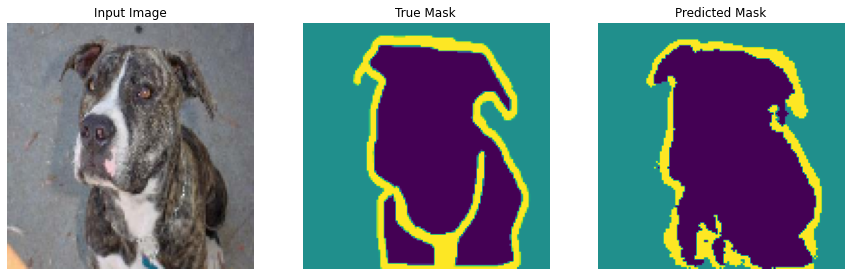

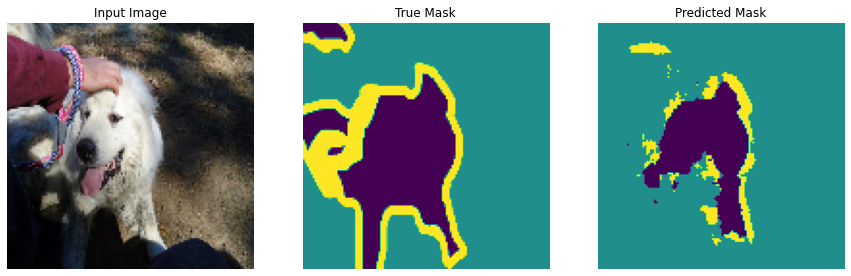

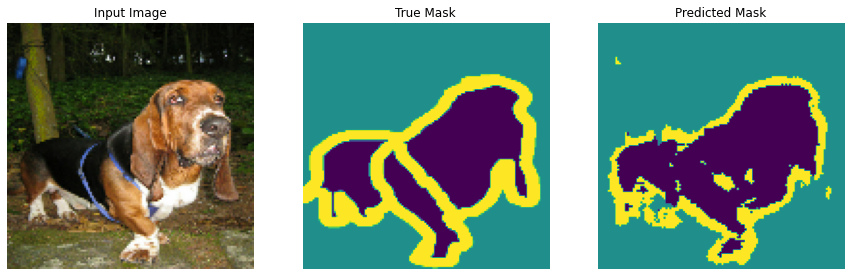

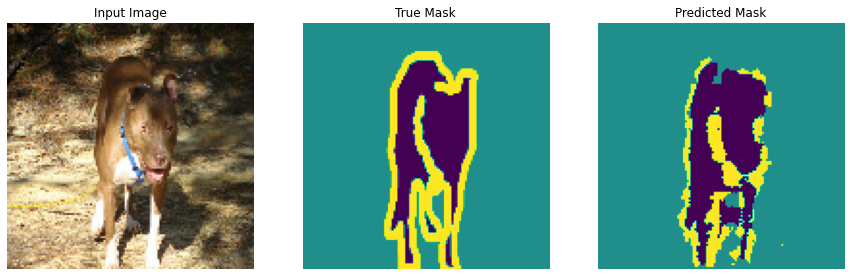

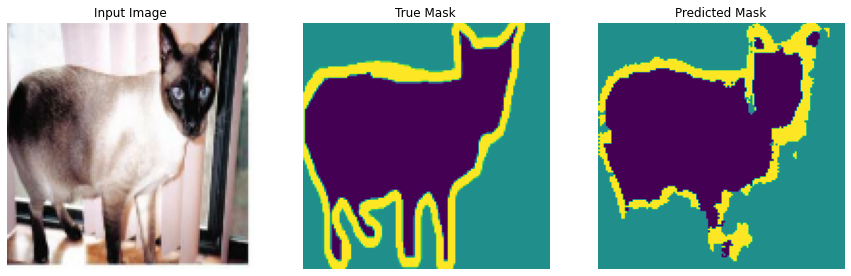

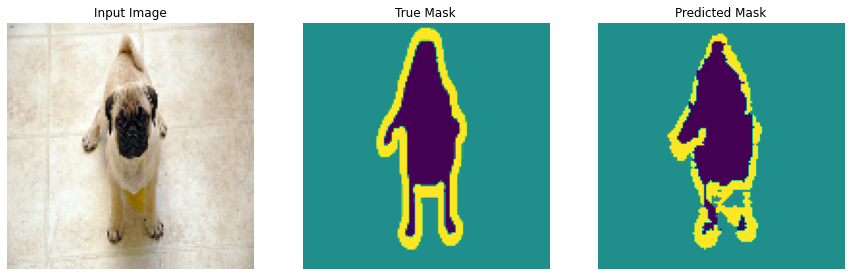

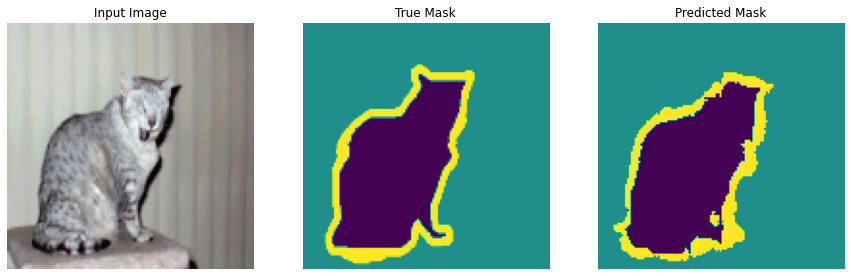

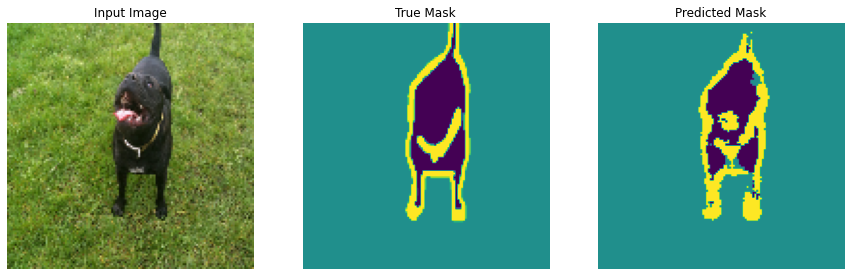

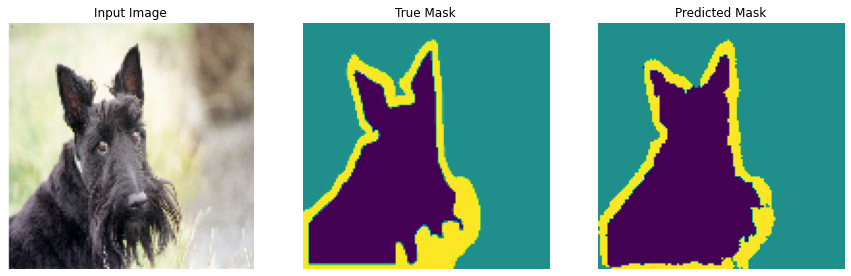

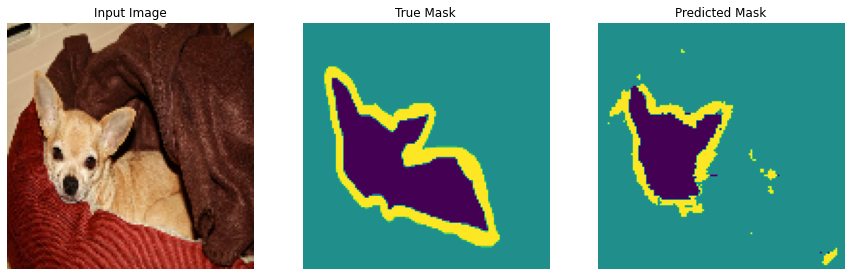

In [ ]:
show_predictions(test_ds,num=15)